# ML Zoomcamp 2023 – Second Capstone Project

[Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs)

In [1]:
import os
import re
from pathlib import Path
from time import time
import xml.etree.ElementTree as ET
from skimage.io import imread
from skimage.transform import resize
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img

In [3]:
images_dir = 'data/raw/Images'
annotation_dir = 'data/raw/Annotation'
processed_dir = 'data/processed'
img_size = 299

## Data preparation

In [4]:
select_breed_dir_list = ['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 'n02092002-Scottish_deerhound',
                         'n02112018-Pomeranian', 'n02107683-Bernese_mountain_dog', 'n02111889-Samoyed',
                         'n02090721-Irish_wolfhound', 'n02086240-Shih-Tzu', 'n02111500-Great_Pyrenees',
                         'n02111129-Leonberg']

In [5]:
# modified from https://www.kaggle.com/code/hengzheng/dog-breeds-classifier/notebook
breed_dir_list = [name for name in select_breed_dir_list if name not in ['.DS_Store']]
if not Path(processed_dir).exists():
    Path.mkdir(Path.cwd() / processed_dir, exist_ok=True)
    for breed_dir in breed_dir_list:
        breed_name = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', breed_dir)
        breed_name = re.sub(r'-', r'_', breed_name.lower())
        Path.mkdir(Path.cwd() / processed_dir / breed_name, exist_ok=True)
    print(f'''Created {len(os.listdir(processed_dir))} folders to store cropped images of the different breeds.''')
else:
    print(f'Folder {processed_dir} already exists.')

Folder data/processed already exists.


In [6]:
t0 = time()
print(f'Saving {img_size}x{img_size} image sizes.')
if not list(Path(processed_dir).glob('**/*.jpg')):
    for breed_dir in breed_dir_list:
        counter = 0
        for breed_prefix in os.listdir(f'{annotation_dir}/{breed_dir}'):
            img = Image.open(f'{images_dir}/{breed_dir}/{breed_prefix}.jpg')
            tree = ET.parse(f'{annotation_dir}/{breed_dir}/{breed_prefix}')
            xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
            xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
            ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
            ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
            img = img.crop((xmin, ymin, xmax, ymax))
            img = img.convert('RGB')
            img = img.resize((img_size, img_size))
            breed_name = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', breed_dir)
            breed_name = re.sub(r'-', r'_', breed_name.lower())
            img.save(processed_dir + '/' + breed_name + '/' + breed_prefix + '.jpg')
            counter += 1
        print(f'Saved {counter} images in {breed_name} folder.')
    print(f'Time elapsed: {round(time()-t0, 0)} seconds.')
else:
    print(f'Folder {processed_dir} with cropped images already exists.')

Saving 299x299 image sizes.
Folder data/processed with cropped images already exists.


### Removal of corrupted images

In [7]:
num_skipped = 0
for folder_name in select_breed_dir_list:
    breed_dir = Path(processed_dir) / folder_name
    breed_dir = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', str(breed_dir))
    breed_dir = re.sub(r'-', r'_', breed_dir.lower())
    print(f'Looking into folder {str(breed_dir)}')
    for fname in os.listdir(breed_dir):
        fpath = Path(breed_dir) / fname
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print(f"Deleted {num_skipped} images.")

Looking into folder data/processed/maltese_dog
Looking into folder data/processed/afghan_hound
Looking into folder data/processed/scottish_deerhound
Looking into folder data/processed/pomeranian
Looking into folder data/processed/bernese_mountain_dog
Looking into folder data/processed/samoyed
Looking into folder data/processed/irish_wolfhound
Looking into folder data/processed/shih_tzu
Looking into folder data/processed/great_pyrenees
Looking into folder data/processed/leonberg
Deleted 0 images.


## Data generation

In [8]:
image_size_tuple = (img_size, img_size)
batch_size = 32

In [9]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    processed_dir,
    validation_split = 0.2,
    subset = 'both',
    seed = 33,
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = image_size_tuple,
    batch_size = batch_size,
)

Found 2233 files belonging to 10 classes.
Using 1787 files for training.
Using 446 files for validation.


### Data visualization

In [10]:
names = train_ds.class_names

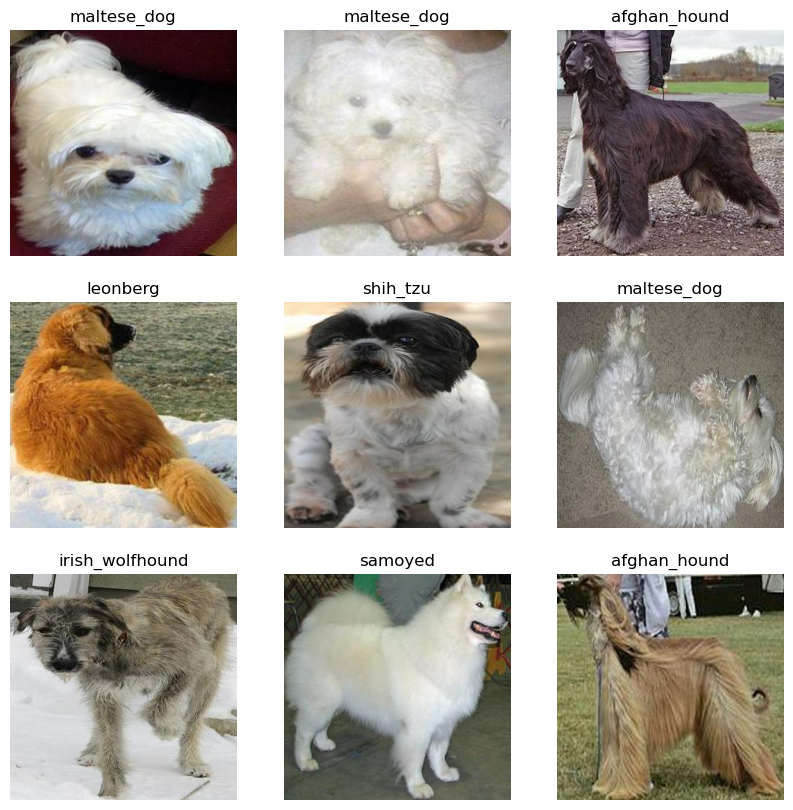

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype('uint8'))
        plt.title(names[list(labels[i]).index(1)])
        plt.axis('off')

## Pre-trained convolutional neural networks

In [12]:
model = Xception(weights='imagenet', input_shape=(img_size, img_size, 3))

In [13]:
path_to_image = 'data/processed/scottish_deerhound/n02092002_109.jpg'
img = load_img(path_to_image, target_size=(299, 299))
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)
pred = model.predict(X)
decode_predictions(pred)

1/1 [==============================] - 1s 856ms/step


[[('n02092002', 'Scottish_deerhound', 0.80573595),
  ('n02090721', 'Irish_wolfhound', 0.04460486),
  ('n02090622', 'borzoi', 0.0046337303),
  ('n02091244', 'Ibizan_hound', 0.002903115),
  ('n02100236', 'German_short-haired_pointer', 0.0027202833)]]

## Transfer learning

Using a small image size to decrease training time.

In [14]:
image_size = 299
base_model = Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model.trainable = False
inputs = keras.Input(shape=(image_size, image_size, 3))
base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(10)(vectors)
model = keras.Model(inputs, outputs)

In [15]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, epochs = 10, validation_data = val_ds)